# **Eda y Modelamiento del Modelo**

El notebook que se presenta a continuación corresponde a todo el procedimiento que se llevó a cabo para poder selecionar correctamente las features para el entrenamiento del Modelo de Predición de Precios.

## **Carga de Datos y Librerías**

In [8]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

df_games = pd.read_csv('/content/drive/MyDrive/datasets/steam_games_PI.csv', index_col=[0])
df_games.head(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


### **Consideraciones**

De acuerdo a la previsualización anterior de los datos, se pudo observar como gran parte de los datos provistos corresponden a valores categóricos o a valores anidados. Solo se tienen tres columnas de naturaleza numérica, y al momento de desarrollar un modelo de predicción de precios, es necesario la presencia de columnas numéricas con una correlacion lineal capaz de describir el comportamiento del precio. En este sentido, desde antes de completar el análisis y la selección de features, ya se pudo preveer una falta de campos numéricos y una dificultad para lograr un modelo con precisión.

Por otro lado, debido a la misma ausencia de campos numéricos, se consideró necesario aprovechar al máximo las features numéricas disponibles y, de ser posible, crear nuevos campos númericos a partir de los datos originales.

## **Utilidades**

Dentro del archivo utils, se encuentran una serie de funciones que fueron utuilidas para la transformacion de datos

In [10]:
from sklearn import preprocessing
from ast import literal_eval

def label_encode_columns(df, columns):
    encoding_dict = {}
    for col in columns:
        le = preprocessing.LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return encoding_dict

def get_list_elements(df, column):
    df = df.copy()
    elements_dict = {}

    def read_list(el_list):
        if isinstance(el_list, str):
            for el in list(literal_eval(el_list)):
                if el in elements_dict :
                    elements_dict[el] += 1
                else:
                    elements_dict[el] = 1

    df[column].map(lambda x: read_list(x))
    return elements_dict

def element_in_list(list_str, tag):
    if isinstance(list_str, str):
        list_str = list(literal_eval(list_str))
        if tag in list_str :
            return 1
        else:
            return 0
    else:
        return 0

def tag_to_hot_encoding(df, column, tag):
    df[tag] = df[column].map(lambda el_list: element_in_list(el_list, tag))


def create_column_tags(df, list_column, new_column, tags):

  def read_list(el_list):
    if isinstance(el_list, str):
      list_of_tags = list(literal_eval(el_list))
      for tag in tags:
        if tag in list_of_tags:
          return 1
    return 0

  df[new_column] = df[list_column].map(lambda x: read_list(x))

def number_of_items(df, list_column):

  def read_list(el_list):
    if isinstance(el_list, str):
      list_of_tags = list(literal_eval(el_list))
      return len(list_of_tags)
    return 0

  column_name = 'Number_of_' + list_column
  df[column_name] = df[list_column].map(lambda x: read_list(x))

## **Columnas Innecesarias**

La idea del modelo fue predecir el precio en base a la características propias del videojuegos: como el género, las especficaciones técnicas y el año del lanzamiento. En este sentido, se consideraron incesasarias las siguientes columnas:

- **Url**: URL innecesaria.
- **Reviews_url**: URL innecesaria.
- **Developer**: No se considero importante debido a la enorme cantidad de desarrolladores.
- **Publisher**: No se considero importante debido a la enorme cantidad de distribuidores.
- **Discount_price**: Irrelevante para el análisis.
- **Id**: Identificador innecesario.
- **App_name**: Identificador innecesario.
- **Title**: Identificador innecesario.

In [11]:
cols_to_drop = [
  'url',
  'reviews_url',
  'developer',
  'discount_price',
  'publisher',
  'id',
  'app_name',
  'title'
]

df_games = df_games.drop(cols_to_drop, axis=1)

## **Valores Nulos y Duplicados**

Los valores nulos se distribuyeron de la siguiente manera.

In [12]:
df_games.isna().sum()

genres           3283
release_date     2067
tags              163
specs             670
price            1377
early_access        0
sentiment        7182
metascore       29528
dtype: int64

La cantidad de videojuegos se consideró mucha para la clase de predición que se requiere hacer y la naturaleza poco lineal de los datos. Por esto mismo, al examinar la gran cantidad de valores nulos de metascore, se consideró utilizar esta columna para filtrar únicamente los juegos importantes o que hayan recibido una valoración por la crítica.

In [13]:
df_games = df_games.dropna(subset=['metascore'])
print("Número de registros:", df_games.shape[0])
df_games.isna().sum()

Número de registros: 2607


genres          62
release_date    54
tags             1
specs            4
price           23
early_access     0
sentiment       21
metascore        0
dtype: int64

Como el número de registros nulos se redujo con consideración, el resto simplemente se eliminó.

In [14]:
df_games = df_games.dropna()
df_games = df_games.drop_duplicates()

Por otro lado, para la columnas númericas price, release_data y metascore se elimino la presencia de todo dato no numerica que pudiera existir dentro del dataset.

In [15]:
# Fechas de lanzamiento
df_games['release_date'] = pd.to_datetime(df_games['release_date'], errors='coerce').dt.year
df_games = df_games.dropna(subset=['release_date']).copy()
df_games['release_date'] = df_games['release_date'].astype('int')

# Metascore
df_games['metascore'] = df_games['metascore'].astype('float')

# Precios
df_games['price'] = pd.to_numeric(df_games['price'], errors='coerce').copy()
df_games = df_games.dropna(subset=['price']).copy()
df_games['price'] = df_games['price'].astype('int').copy()

Cabe resaltar, que en la columna price existe una gran cantidad de categorias , pero este tipo de dato no representa una aproximacion, si no una actegoria que define a un juego como gratis. Es por ello, que ningun gratutito fue incluido dentro del analisis, y en cambio, en el desarrollo de la Api, se aclaro que el modelo solo funciona con modelos, por que se sobreentiende que el precio es 0 en caso de ser Free To Play

In [16]:
df_games = df_games[df_games['price'] != 0]

## **Outliers**


### **Variables Númericas**

Solo se dispuso de tres variables numéricas dentro del dataset:

In [17]:
df_games.describe()

,release_date,price,metascore
count,2414.000000,2414.000000,2414.000000
mean,2012.041011,14.144159,72.227838
std,4.424854,10.339890,10.762953
min,1993.000000,1.000000,20.000000
25%,2010.000000,9.000000,66.000000
50%,2013.000000,11.000000,74.000000
75%,2015.000000,19.000000,80.000000
max,2017.000000,99.000000,96.000000



### **Precio**

<Axes: xlabel='price'>

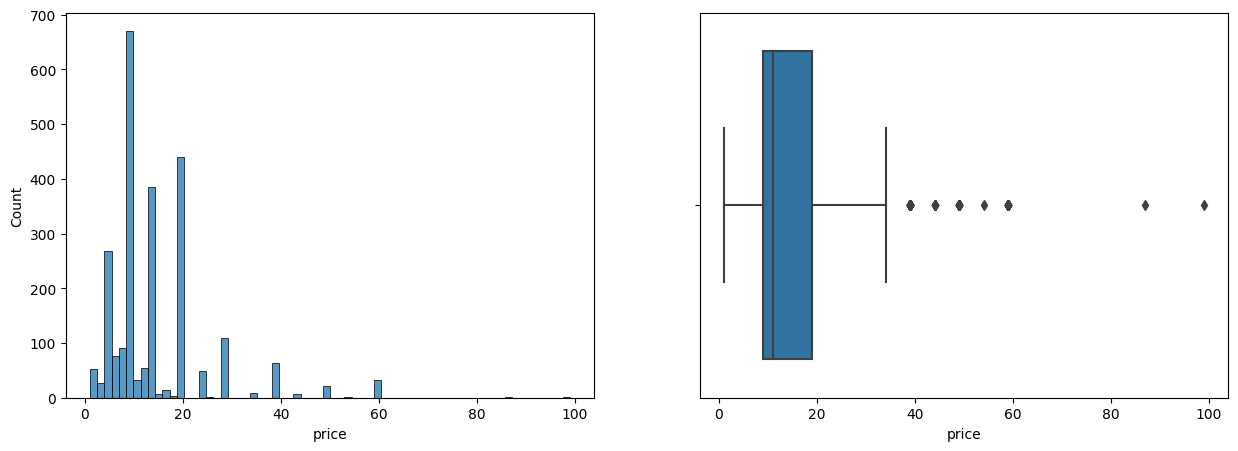

In [18]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

sns.histplot(ax=ax[0], data=df_games, x='price')
sns.boxplot(ax=ax[1], data=df_games, x='price')

Viendo los graficos, se pudo observer como la mayor distribución de los de steam esta en un rango entre 2 y 20 dolares. Lo mismo ocurre en blox plot, en donde la mayor distribucion de juegos se denota entre los diez a viente dolares, y todo valor mayor a aproximadamente 30 es marcado como outilier.

No se puece considerar que un videojuego de 30 o 40 dolares no existan, pero en este caso particular, todo videojuego con un precio mayor a 60 fue elimiando por considerare muy caro y disntancia a la distribucion principal del dataset.

In [19]:
df_games = df_games[df_games['price'] < 60]

Para el resto de variables numéricas, se consideró limitar un rango para eliminar posibles outliers. En caso de Metascore, entre 0 a 100, y en fecha de lanzamiento, una fecha más antigua a 1985 o más vieja de 2022.

In [20]:
df_games = df_games[(df_games['metascore'] <= 100) & (df_games['metascore'] >= 0)]
df_games = df_games[(df_games['release_date'] <= 2022) & (df_games['release_date'] >= 1985)]

## **Variables Categóricas**

## **Sentimiento**

Los sentimientos disponibles son:

In [21]:
df_games.groupby('sentiment')['sentiment'].count()

sentiment
1 user reviews                8
2 user reviews                7
3 user reviews                6
4 user reviews                5
5 user reviews                6
6 user reviews                7
7 user reviews                7
8 user reviews                9
9 user reviews                7
Mixed                       483
Mostly Negative              49
Mostly Positive             457
Negative                      3
Overwhelmingly Negative       2
Overwhelmingly Positive     162
Positive                    116
Very Negative                 4
Very Positive              1074
Name: sentiment, dtype: int64

Como exisen sentimientos que representan un número de N reviews en lugar de un sentimiento en sí, se imputaron estos datos con "Mixed" considerando estos como un valor neutro.

In [22]:
sentiments_mixes = [f'{x} user reviews' for x in range(1, 10)]
df_games['sentiment'] = df_games['sentiment'].map(lambda x: 'Mixed' if x in sentiments_mixes else x)
df_games.groupby('sentiment')['sentiment'].count()

sentiment
Mixed                       545
Mostly Negative              49
Mostly Positive             457
Negative                      3
Overwhelmingly Negative       2
Overwhelmingly Positive     162
Positive                    116
Very Negative                 4
Very Positive              1074
Name: sentiment, dtype: int64

### **LabelEncoding**

In [23]:
label_encode_columns(df_games, ['early_access'])
label_encode_columns(df_games, ['sentiment'])

{'sentiment': {'Mixed': 0,
  'Mostly Negative': 1,
  'Mostly Positive': 2,
  'Negative': 3,
  'Overwhelmingly Negative': 4,
  'Overwhelmingly Positive': 5,
  'Positive': 6,
  'Very Negative': 7,
  'Very Positive': 8}}

## **Datos Anidados**

Para las columnas en donde los datos eran listas, se tomó en considerancion evaluar la cantidad de elementos diferentes en cada columna para determinar como tratar los datos anidados:

In [24]:
print("Cantidad de Géneros diferentes:", len(list(get_list_elements(df_games, 'genres'))))
print("Cantidad de Etiquetas diferentes:", len(list(get_list_elements(df_games, 'tags'))))
print("Cantidad de Especificaciones diferentes:", len(list(get_list_elements(df_games, 'specs'))))

Cantidad de Géneros diferentes: 12
Cantidad de Etiquetas diferentes: 321
Cantidad de Especificaciones diferentes: 27


Se trataron los datos para dos casos particulares:

### **Número de Especificaciones y Etiquetas**

Para las especificaciones y etiquetas, como la cantidad de items era mucha como para hacer un Hot Encoding, se hizo una nueva columna para con la cantidad de elementos que tenía un videojuegos en cada columna.

In [25]:
number_of_items(df_games, 'tags')
number_of_items(df_games, 'specs')

### **Géneros**

En este caso, como habían solo 12 géneros diferentes en el dataset, si se hizo un One Hot Encoding de los elementos en la columna.

In [26]:
genres = list(get_list_elements(df_games, 'genres'))
for genre in genres:
    tag_to_hot_encoding(df_games, 'genres', genre)

## **Selección de Features**

Al evaluar la correlacion de Pearson, se obtuvo lo siguiente:

<ipython-input-36-ed823e467785>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_games.corr()


<Axes: >

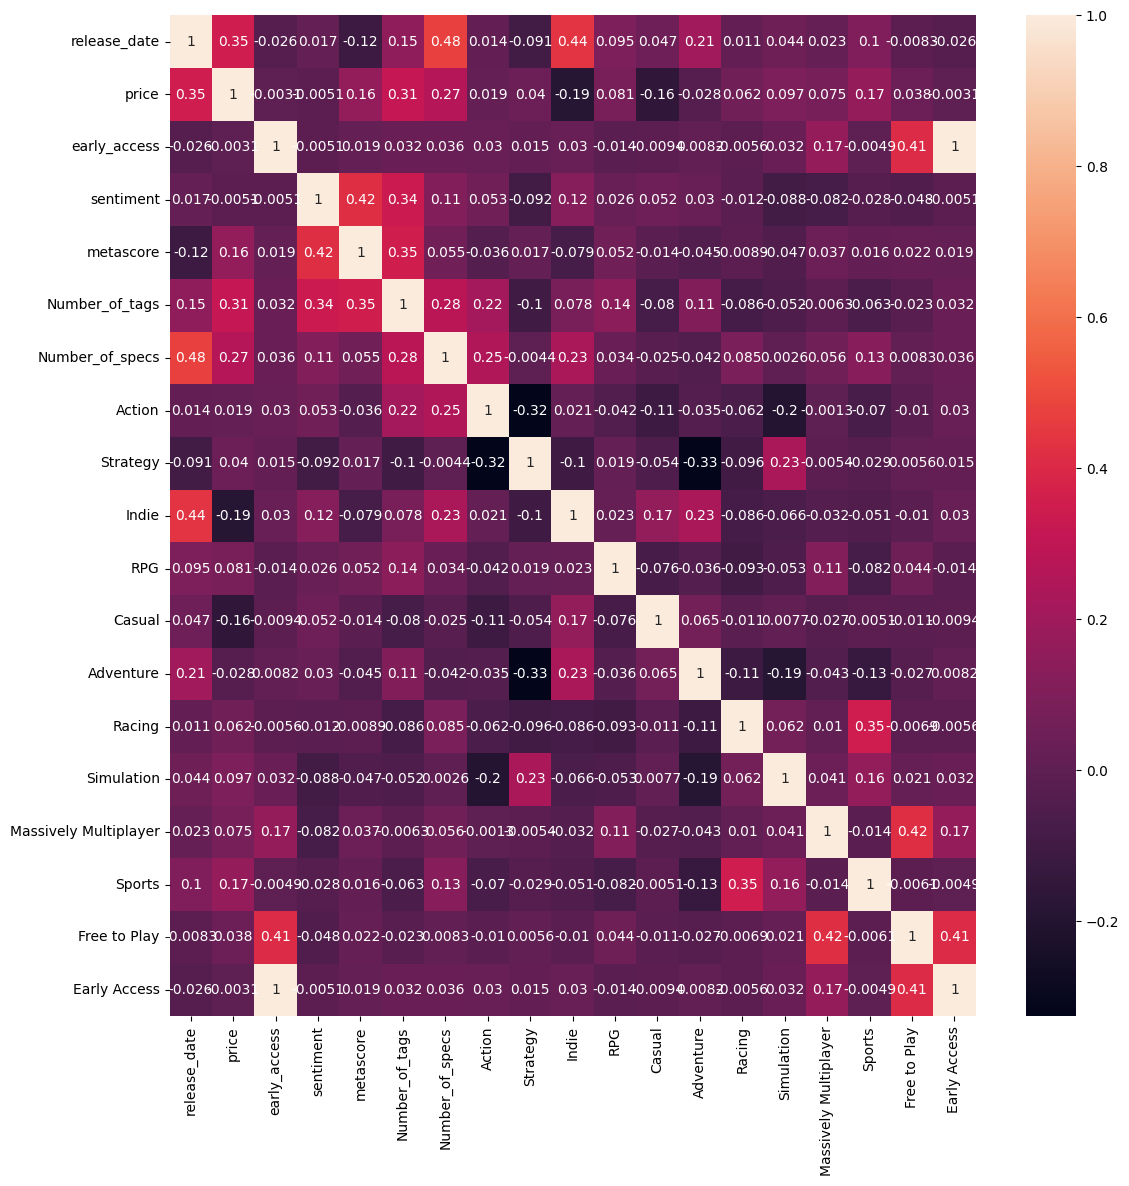

In [36]:
plt.figure(figsize=(13, 13))
corr = df_games.corr()
sns.heatmap(corr, annot = True)

Como se comentó al comienzo del análisis, ya se podía esperar desde un inicio malas correlaciones con el precio o variable objetivo por parte de las demas features. Esto implica, que independientemente del modelo que se use, díficilmente se pueda crear una modelo preciso con los datos que se disponen.

Al final, se seleccionaron todas las variables numéricas que se tenían, siendo el número de etiquetas y el año de lanzamiento las más correlacionadas con 0.31 y 0.35 respectivamente, y se usaron los géneros más relevantes o más conocidos.

## **Evaluación de los Modelos**

Como la naturaleza de los datos no resutó favorable para el tipo de modelo de Regresión, se hizo uso de un algoritmo de evaluación de múltiples modelos con el fin de determinar es mejor modelo para este caso en particular.

In [29]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# Metricas de Evaluación
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error

# Separa muestra de entrenamiento
from sklearn.model_selection import train_test_split

En la mayoría de los casos, se aplicó un grid search básico para hiperoptimización de parámetros.

In [30]:
param_grid = {
  'LinearRegression': {},
  'Lasso': {'alpha': (np.logspace(-10, 10, 200))},
  'Ridge': {'alpha': (np.logspace(-10, 10, 200))},
  'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]},
  'Lars': {},
  'SGDRegressor': {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l1', 'l2']},
  'KNeighborsRegressor': {'n_neighbors': [3, 5, 7]},
  'DecisionTreeRegressor': {'max_depth': [None, 10, 20]},
  'BaggingRegressor': {}
}

Algoritmo de Evaluación.

In [34]:
import time
from sklearn.model_selection import GridSearchCV

accuracies = {}
hyperparameters = {}
classifiers_models = {}
RMSE = {}
RMA = {}
R2 = {}

X = df_games[['release_date', 'Number_of_tags','Number_of_specs', 'metascore', 'sentiment','Indie', 'Casual', 'Action'	,'Sports',	'Racing',	'Strategy',	'RPG', 'Simulation']]
y = df_games['price'].astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

models_params = [
  (LinearRegression(), param_grid['LinearRegression']),
  (Lasso(), param_grid['Lasso']),
  (Ridge(), param_grid['Ridge']),
  (ElasticNet(), param_grid['ElasticNet']),
  (Lars(), param_grid['Lars']),
  (SGDRegressor(), param_grid['SGDRegressor']),
  (KNeighborsRegressor(), param_grid['KNeighborsRegressor']),
  (DecisionTreeRegressor(), param_grid['DecisionTreeRegressor']),
  (BaggingRegressor(), param_grid['BaggingRegressor'])
]

for model, params in models_params:
  # Entrenamiento
  start = time.time()
  grid_clf = GridSearchCV(model, param_grid=params, cv=3)
  grid_clf.fit(X_train,y_train)
  end = time.time()
  trainingTime = end - start

  # Evaluación
  start = time.time()
  accuracy = grid_clf.score(X_test, y_test)
  end = time.time()
  testingTime = end - start

  #Predicción
  y_pred = grid_clf.predict(X_test)

  # Resultado
  accuracies[model.__class__.__name__] = accuracy
  hyperparameters[model.__class__.__name__] = str(grid_clf.best_params_)
  classifiers_models[model.__class__.__name__] = model
  RMSE[model.__class__.__name__] =  mean_squared_error(y_test, y_pred, squared=False)
  RMA[model.__class__.__name__]  = mean_absolute_error(y_test, y_pred)
  R2[model.__class__.__name__] = accuracy * 100

  print(f"{model.__class__.__name__} | training time: {trainingTime:.2f} seconds, testing time: {testingTime:.2f} seconds, { mean_squared_error(y_test, y_pred, squared=False)}")

best_classifier = max(accuracies, key=accuracies.get)
print("-----------------------------------")
print(f"Best regressor: {best_classifier}")
print(f"Best hyperparameters: {hyperparameters[best_classifier]}")
print(f"Best R2: {R2[best_classifier]}")
print(f"Best RMSE: {RMSE[best_classifier]}")
print(f"Best RMA: {RMA[best_classifier]}")

LinearRegression | training time: 0.03 seconds, testing time: 0.01 seconds, 8.29736041066649
Lasso | training time: 4.42 seconds, testing time: 0.01 seconds, 8.30246312336734
Ridge | training time: 5.17 seconds, testing time: 0.00 seconds, 8.308916245305458
ElasticNet | training time: 0.21 seconds, testing time: 0.01 seconds, 8.370013028765081
Lars | training time: 0.07 seconds, testing time: 0.01 seconds, 8.297360410666471
SGDRegressor | training time: 0.23 seconds, testing time: 0.00 seconds, 2592090011551782.0
KNeighborsRegressor | training time: 0.15 seconds, testing time: 0.01 seconds, 9.291131282059332
DecisionTreeRegressor | training time: 0.08 seconds, testing time: 0.00 seconds, 9.802649945485927
BaggingRegressor | training time: 0.20 seconds, testing time: 0.01 seconds, 8.141800584048886
-----------------------------------
Best regressor: BaggingRegressor
Best hyperparameters: {}
Best R2: 37.58147769310739
Best RMSE: 8.141800584048886
Best RMA: 5.6611432160804025


## **Exportar Modelo**

De acuerdo a los datos obtenidos, para este caso de predicción y para las features selectas, el mejor modelo fue el BaggingRegressor Sin ajuste de hiperparametros, con un R2 de 37.58 y un RMSE de 8.14,

Este modelo se entrenó nuevamente y se exportó ya entrenado en un archivo pkl para su posterior consumo en la API.

In [35]:
model = BaggingRegressor()
model = GridSearchCV(model, param_grid=params, cv=3)
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.37217188057306083

In [ ]:
import pickle

pkl_file = open('fitted_model.pkl', 'ab')
pickle.dump(model, pkl_file)
pkl_file.close()